In [4]:
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.cluster import KMeans
import pandas as pd
from sklearn import metrics
from scipy.spatial.distance import cdist
import imageio

from lib.file.ROI_reader import ROIFileReader
from lib.analysis.laminar_dist import LaminarROI
from lib.analysis.align import ImageAlign
from lib.utilities import *
# implementation of single-cell identification as outlined in 
# https://www.proquest.com/docview/2838882181?pq-origsite=gscholar&fromopenview=true&sourcetype=Dissertations%20&%20Theses
# and implemented in R/Python here: https://github.com/ksscheuer/ROI_Identification
# https://github.com/ksscheuer/Single_Cell_Identification/blob/main/AutomaticallyChooseROIs_part1.R


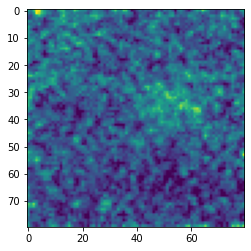

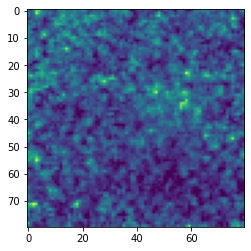

In [15]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/01-15-24/converted_zda/"
target_recording = '02_02_02'
# input files: *_amp.dat, *_snr.dat
cluster_SNRcutoff = 1
k_choice = 4  # none is auto

ROI_px_cutoff = 9
SNR_cutoff = 2.5
Amp_cutoff = 1

data = {}
for fn in ['_amp.dat', '_snr.dat']:
    fn2 = data_dir + target_recording + fn
    data_arr = pd.read_csv(fn2,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    data_arr = np.array(data_arr['Values']).reshape((80, 80))
    plt.imshow(data_arr)
    plt.show()
    data[fn] = data_arr

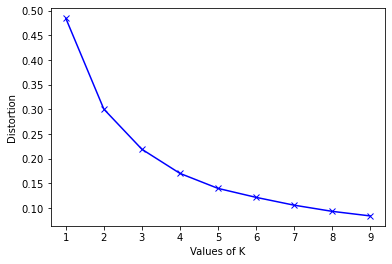

In [16]:
# elbow plot
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = data['_snr.dat'].reshape((-1,1))

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.show()

[[0 3 0 ... 3 0 2]
 [0 3 0 ... 1 3 0]
 [0 3 0 ... 3 3 3]
 ...
 [3 0 0 ... 3 1 1]
 [2 0 1 ... 2 0 0]
 [0 3 1 ... 2 0 0]]


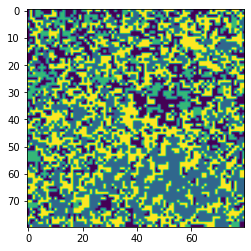

In [17]:
# Step1 produce: Density plot of SNR for all pixels,
#         K-means clustering plot of heatmap with cutoff applied
# Step2 produce: remove ROIs with diameters > cutoff

# K-means cluster on SNR data
km = KMeans(n_clusters=k_choice)
km.fit(data['_snr.dat'].reshape((-1,1)))
labels = km.predict(data['_snr.dat'].reshape((-1,1)))
labels = labels.reshape((80,80))
plt.imshow(labels)
print(labels)
plt.show()

[[1.51787  1.02484  1.78454  ... 0.725058 1.92076  2.09106 ]
 [1.76981  1.26216  1.73715  ... 0.631913 1.07512  1.5346  ]
 [1.88516  1.17666  1.51147  ... 0.916066 0.752417 1.07875 ]
 ...
 [1.10564  1.39164  1.50663  ... 1.03486  0.207971 0.159955]
 [3.00866  1.4139   0.436291 ... 2.44072  1.38837  1.81165 ]
 [1.91381  1.06519  0.487692 ... 2.87006  1.8397   1.93439 ]]
[[1.51787  1.02484  1.78454  ... 0.725058 1.92076  2.09106 ]
 [1.76981  1.26216  1.73715  ... 0.631913 1.07512  1.5346  ]
 [1.88516  1.17666  1.51147  ... 0.916066 0.752417 1.07875 ]
 ...
 [1.10564  1.39164  1.50663  ... 1.03486  0.207971 0.159955]
 [3.00866  1.4139   0.436291 ... 2.44072  1.38837  1.81165 ]
 [1.91381  1.06519  0.487692 ... 2.87006  1.8397   1.93439 ]]
[[1.51787  1.02484  1.78454  ... 0.725058 1.92076  2.09106 ]
 [1.76981  1.26216  1.73715  ... 0.631913 1.07512  1.5346  ]
 [1.88516  1.17666  1.51147  ... 0.916066 0.752417 1.07875 ]
 ...
 [1.10564  1.39164  1.50663  ... 1.03486  0.207971 0.159955]
 [3.008

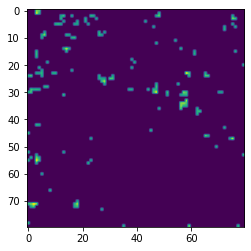

In [18]:
def get_cluster_value(k, labels, values):
    print(values)
    n, m = labels.shape
    ls = []
    for i in range(n):
        for j in range(m):
            if k == labels[i][j]:
                ls.append(values[i][j])
    return np.mean(ls)
                
snr = data['_snr.dat']
amp = data['_amp.dat']
cluster_snrs = [get_cluster_value(k, labels, data['_snr.dat']) for k in range(k_choice)]
for i in range(len(cluster_snrs)):
    if cluster_snrs[i] < cluster_SNRcutoff:
        print("remove cluster", i, "cluster SNR:", cluster_snrs[i])
        snr[labels == i] = 0

snr[snr < SNR_cutoff] = 0
snr[amp < Amp_cutoff] = 0
plt.imshow(snr)

[4, 3, 7, 1, 3, 3, 3, 3, 1, 2, 1, 2, 4, 4, 4, 1, 1, 4, 1, 3, 2, 1, 2, 1, 1, 6, 1, 1, 2, 3, 3, 2, 7, 3, 6, 1, 2, 6, 2, 1, 2, 5, 2, 1, 8, 1, 4, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 6, 1, 2, 2, 1, 1, 5, 6, 1, 1, 1, 1, 1]


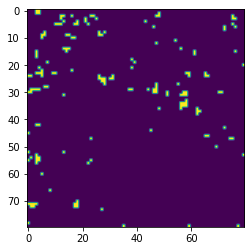

173.0


In [19]:
# pixel size cutoffs

def get_ROI(i, j, snr, visited):
    """ marks all contiguous pixels visited in the process """
    n, m = snr.shape
    visited[i][j] = 1
    if snr[i][j] == 0:
        return []
    roi = [[i, j]]
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            ii = i + dx 
            jj = j + dy
            if 0 <= ii < n and 0 <= jj < m and visited[ii][jj] == 0:
                roi +=  get_ROI(ii, jj, snr, visited)
    return roi
    
n, m = snr.shape
visited = np.zeros((n, m))
survivors = []
for i in range(n):
    for j in range(m):
        if visited[i][j] == 0:
            roi = get_ROI(i, j, snr, visited)
            if 0 < len(roi) < ROI_px_cutoff:
                survivors.append(roi)
print([len(s) for s in survivors])
kkm_roi_map = np.zeros((n, m))
for roi in survivors:
    for px in roi:
        i, j = px
        kkm_roi_map[i][j] = 1
        
plt.imshow(kkm_roi_map)
plt.show()
print(np.sum(kkm_roi_map))

[[5515, 5595, 5596], [5020, 5100, 5101], [4318, 4398], [4630, 4629, 4709], [5327, 5328], [5245, 5244], [4759, 4758], [3894, 3893], [2628, 2627], [2149, 2148, 2228], [1914, 1913], [1270, 1189, 1269], [1582, 1581, 1501], [1974, 1973, 1893], [3636, 3635, 3556], [4025, 4024], [3155, 3156, 3075], [3309, 3228, 3308], [3224, 3223, 3143], [3140], [2818, 2897, 2898], [2496], [2268, 2267], [2517, 2436, 2516], [2284, 2285, 2364], [1416, 1415, 1335], [1493, 1492], [855, 856], [1564, 1565, 1644], [1470, 1390], [1067, 987, 1066], [4128, 4127], [4663, 4583], [2933, 2935, 2934, 2854], [3823, 3743, 3742, 3822], [3119], [3243, 3163, 3242], [3648, 3647, 3567], [2238, 2237, 2317, 2318], [4695, 4697, 4696, 4616]] 40
[[[75, 68], [75, 69], [76, 69]], [[60, 62], [60, 63], [61, 63]], [[78, 53], [78, 54]], [[70, 57], [69, 57], [69, 58]], [[47, 66], [48, 66]], [[45, 65], [44, 65]], [[39, 59], [38, 59]], [[54, 48], [53, 48]], [[68, 32], [67, 32]], [[69, 26], [68, 26], [68, 27]], [[74, 23], [73, 23]], [[70, 15], [

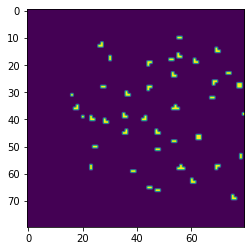

104.0


In [21]:
# read in red labels 
tdTomato_rois = 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/01-15-24/converted_zda/ROIs-red.dat'

rfr = ROIFileReader(tdTomato_rois)
red_rois = rfr.get_roi_list()

print(red_rois, len(red_rois))
red_rois = [LaminarROI(rr).get_points() for rr in red_rois]
print(red_rois, len(red_rois))
red_roi_map = np.zeros((n, m))
for roi in red_rois:
    for px in roi:
        i, j = px
        red_roi_map[j][i] = 1
plt.imshow(red_roi_map)
plt.show()
print(np.sum(red_roi_map))

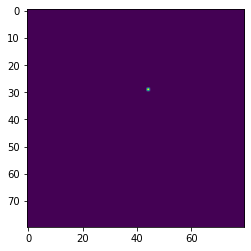

1


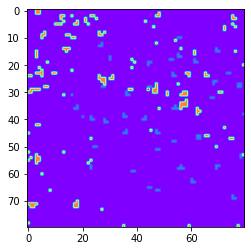

In [22]:
# overlap of red_roi_map and kkm_roi_map
overlap_map = np.logical_and(red_roi_map, kkm_roi_map)
plt.imshow(overlap_map)
plt.show()
print(np.sum(overlap_map))

superpose_map = red_roi_map + kkm_roi_map*5
plt.imshow(superpose_map, cmap='rainbow')